# EECS 16ML Week 5 Assignment: Bayesian Networks

## 0: Getting Started

### 0.1: Introduction to the Assignment 

This week in class, we covered Bayesian Networks - probabilistic graph based modelling tools that rely on Bayesian inference for certain probability computations/queries. They aim to model conditional independences and dependences between a set of events (and thus causation) via their structure which is discussed later on. As we saw in class, having. domain knowledge is particularly useful when it comes to modelling Bayes Nets - and that should be clearer by the end of this assignment.

In this course so far, we have covered a lot of the theory behind Bayesian Networks - whether it be construction, inference, parameter estimation, or structure learning. We have also seen how large Bayes Nets can get - see the picture below which shows a Bayes Net of certain diseases and their effects. 

#### A Pretty Large Bayes Net of certain diseases and their effects
<img src="images/0_large_bayes_net.jpg" width=600 height=600 />

As a result of how large Bayes Nets can get, we need a way to program Bayes Nets and do all our inference and prediction calculations using a computer. For this, will be using the well known Python library [Pomegranate](https://pomegranate.readthedocs.io/en/latest/BayesianNetwork.html#fitting). You are welcome to and encouraged to explore the library and its uses.

This assignment is divided into various segments - in each segment you will use Pomegranate to reinforce the Bayes Net theory you learnt and learn how to program this theory. In the case of certain algorithms learnt in class such as those for parameter estimation and structure learning, you will also get first hand experience with how to implement and test out/compare these algorithms against the library version. The reason behind this is that while it is easy (and important) to be able to call the right library functions, it is also important to be able to know what is going on behind the scenes and implement this in case you may need to make minor modifications to well known algorithms (which is quite often the case in research and the industry).

These are the following sections in this notebook:

<b>0. Getting Started:</b> The current section - which involves a brief introduction to the assignment and setting up of the required libraries

<b>1. Bayes Net Construction and Basic Inference:</b> This section will involve learning how to use Pomegranate to construct basic Bayesian Networks and how inference can be carried out with them.

<b>2. Parameter Estimation and Involved Algorithms:</b> In this section you will learn how Pomegranate can be used to invoke techniques seen in lecture such as MLE to learn certain parameters. You will also code your own version of an algorithm to do this.

<b>3. Structure Construction and Involved Algorithms:</b> This section is similar in structure to the previous one. You will learn how Pomegranate can be used to invoke Bayes Net structure construction algorithms and you will also implement your own version of these algorithms.

<b>4. Takeaways and Learning Objectives Satisfied</b>

<b>5. References</b>

### 0.2: Setting up Required Libraries

As mentioned, we will be using the Pomegranate library for this function. Follow the instructions on [this](https://pomegranate.readthedocs.io/en/latest/install.html) page to install Pomegranate. You may need to install [pip](https://pip.pypa.io/en/stable/installing/) in the process. Once you have successfully installed Pomegranate, run the following cell which imports Pomegranate and other required libraries needed for this assignment.

In [79]:
# Needed Imports
import pomegranate
import pygraphviz
import time
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from pomegranate import *
from sklearn.datasets import load_digits
from ipywidgets import interact, interactive, fixed, interact_manual, Layout

It is imperative for the rest of this assignment that the last cell ran without any bugs. If any library could not be imported (not just pomegranate), make sure to install it. Google is your friend - "How to install libraryXYZ?" <b>Do not move on unless the last cell runs without any errors!<b/>
    
NOTE: To install [pygraphviz](https://pygraphviz.github.io/documentation/latest/install.html), you may need to install [graphviz](https://graphviz.org/download/). Download any tools/dependencies you may need using Google Search. If you are having trouble contact sarthakarora@berkeley.edu

## 1: Bayes Net Construction and Basic Inference

Recall the definition of a Bayes Net from lecture:

<img src="images/1_bayes_net_definition.png" width=600 height=600 />

Thus we can see to construct a Bayes Net we will need to build a DAG with conditional probability tables (CPT's) for each node - which defines the probability of values a node can take on conditioned on values all of that nodes parents can take on. In this section we will assume that we know the structure of the Bayes Net and know the CPT's. Let's look at the following Bayes Net. Follow the code below the picture to see how we can construct this Bayes Net using Pomegranate.

#### A Bayesian Network Representing if John or Mary call the police depending on whether an alarm rings which depends can depend on a Burglary or Earthquake
<img src="images/1_alarm_network.png" width=600 height=600 />

### 1.1: Constructing the Bayes Net
#### Thoroughly read through each code cell below to see how Pomegranate can be used to construct the Bayes Net above. Fill in the blanks where applicable

In [2]:
# We will start of by building the Conditional Probability Tables for each node. Most have been done.
# Use the CPT's filled out for you as an example to fill out the CPT's that have been left blank.

# Burglary Node
possible_values_burglary = ["Burglary", "No Burglary"] # For us to remind ourselves what values this node can take on
burglary_cpt = DiscreteDistribution({"Burglary": 0.001, "No Burglary": 0.999}) # Model nodes with no parents as discrete distributions

# Earthquake Node
possible_values_earthquake = ["Earthquake", "No Earthquake"] 
earthquake_cpt = DiscreteDistribution({"Earthquake": 0.002, "No Earthquake": 0.998})

#Alarm Node
possible_alarm_values = ["Alarm", "No Alarm"]
# Since this node is conditioned on parent/s, we will use the CPT class instead of the DiscreteDistribution class
alarm_cpt = ConditionalProbabilityTable(
        [[ 'Earthquake', 'Burglary', 'Alarm', 0.95 ],
         [ 'Earthquake', 'No Burglary', 'Alarm', 0.29 ],
         [ 'No Earthquake', 'Burglary', 'Alarm', 0.94 ],
         [ 'No Earthquake', 'No Burglary', 'Alarm', 0.001 ],
         [ 'Earthquake', 'Burglary', 'No Alarm', 0.05 ],
         [ 'Earthquake', 'No Burglary', 'No Alarm', 0.71 ],
         [ 'No Earthquake', 'Burglary', 'No Alarm', 0.06 ],
         [ 'No Earthquake', 'No Burglary', 'No Alarm', 0.999 ]], [earthquake_cpt, burglary_cpt]) # Need to pass in Parent CPT's in same order
# NOTE: Each row corresponds to a CPT entry. The last column (3rd in this case) of each entry
# is the value of the node this CPT corresponds to. The preceding columns are values of the parent nodes
# of this alarm node (Earthquake and Burglary). The order of the columns of parents has to be the same
# as the order of the parent CPT's passed into the ConditionalProbabilityTable constructor which in the above 
# case is [earthquake_cpt, burglary_cpt].

# John Node
possible_john_values = ["John Calls", "John Doesn't Call"]
john_cpt = ConditionalProbabilityTable(
        [[ "Alarm", "John Calls", 0.9 ],
         [ "No Alarm", "John Calls", 0.05 ],
         [ "Alarm", "John Doesn't Call", 0.1 ],
         [ "No Alarm", "John Doesn't Call", 0.95 ]], [alarm_cpt]) 

# Mary Node
possible_mary_values = ["Mary Calls", "Mary Doesn't Call"]
mary_cpt = ConditionalProbabilityTable(
        [[ "Alarm", "Mary Calls", 0.7 ],
         [ "No Alarm", "Mary Calls", 0.01 ],
         [ "Alarm", "Mary Doesn't Call", 0.3 ],
         [ "No Alarm", "Mary Doesn't Call", 0.99 ]], [alarm_cpt]) 


In [3]:
# Next, we formalise each Node and its CPT as a state object
burglary_state = State(burglary_cpt, name="burglary")
earthquake_state = State(earthquake_cpt, name="earthquake")
alarm_state = State(alarm_cpt, name="alarm")
john_state = State(john_cpt, name="john")
mary_state = State(mary_cpt, name="mary")

In [4]:
# Next, we need to create a Bayesian Network Model, with a name, and add our states to this model
model = BayesianNetwork("Alarm Bayes Net")
model.add_states(burglary_state, earthquake_state, alarm_state, john_state, mary_state)

In [5]:
# Next, we will add edges to our model representing parent-child relationships between states
# The call to do this looks like model.add_edge(parent, child) and edges look like parent --> child
model.add_edge(burglary_state, alarm_state)
model.add_edge(earthquake_state, alarm_state)
model.add_edge(alarm_state, john_state)
model.add_edge(alarm_state, mary_state)

In [6]:
# Finally, we must bake our model to finish preparing it
model.bake()

Congratulations! If the cells above did not error, you now know how to build a Bayes Net using Pomegranate! Run the cells below to see how the Bayes Net has been stored by Pomegranate. You do not need to fully understand the output of the following two cells - it is just if you are curious! (If the cells above did error, check your answers and retry)

In [7]:
model.graph # A graph representation of the Bayes Net as stored by Pomegranate

{
    "class" : "FactorGraph",
    "name" : "Alarm Bayes Net-fg",
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "dtype" : "str",
                "name" : "DiscreteDistribution",
                "parameters" : [
                    {
                        "Burglary" : 0.5,
                        "No Burglary" : 0.5
                    }
                ],
                "frozen" : false
            },
            "name" : "burglary",
            "weight" : 1.0
        },
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "dtype" : "str",
                "name" : "DiscreteDistribution",
                "parameters" : [
                    {
                        "Burglary" : 0.001,
                        "No Burglary" : 0.999
                    }
                ],
                "frozen" : false
     

In [8]:
model.edges # How the states, their distributions, and the edges are stored by Pomegranate

[({
      "class" : "State",
      "distribution" : {
          "class" : "Distribution",
          "dtype" : "str",
          "name" : "DiscreteDistribution",
          "parameters" : [
              {
                  "Burglary" : 0.001,
                  "No Burglary" : 0.999
              }
          ],
          "frozen" : false
      },
      "name" : "burglary",
      "weight" : 1.0
  },
  {
      "class" : "State",
      "distribution" : {
          "class" : "Distribution",
          "name" : "ConditionalProbabilityTable",
          "table" : [
              [
                  "Earthquake",
                  "Burglary",
                  "No Alarm",
                  "0.05000000000000001"
              ],
              [
                  "Earthquake",
                  "Burglary",
                  "Alarm",
                  "0.95"
              ],
              [
                  "Earthquake",
                  "No Burglary",
                  "No Alarm",
                

### 1.2: Prediction and Inference

Now that you know how to build a Bayes Net in Pomegranate, we can move on to something more interesting, prediction and inference. This includes computing answers to certain queries such as finding joint and conditional probabilities that are not directly readable from the CPT's originally given to us in the Bayesian Network. We leverage conditional independence relationships in Bayes Nets to do this inference and as a reminder from lecture:

#### Inference Recap From Lecture
<img src="images/1_inference.png" width=600 height=600 />

You have learnt how to do inference the hard mechanical way in lecture and on other assignments - however it is here on a computer where libraries such as Pomegranate shine and make your life easy. Let's say you're interested in finding P(Burglary, Earthquake, Alarm, John Calls, Mary Calls). This involves multiplying a whole bunch of values to get the joint distribution as you have learnt, but all you have to do in pomegranate is:

In [9]:
# P('Burglary', 'Earthquake', 'Alarm', "John Calls", "Mary Calls")
model.probability([['Burglary', 'Earthquake', 'Alarm', "John Calls", "Mary Calls"]])

1.1969999999999995e-06

Similarly, here are a few more values one may be interested in:

In [10]:
# P('Burglary', 'No Earthquake', 'Alarm', "John Calls", "Mary Doesn't Call")
model.probability([['Burglary', 'No Earthquake', 'Alarm', "John Calls", "Mary Doesn't Call"]])

0.00025329239999999993

In [11]:
# P('Burglary', 'No Earthquake', 'Alarm', "John Doesn't Call", "Mary Doesn't Call")
model.probability([['Burglary', 'No Earthquake', 'Alarm', "John Doesn't Call", "Mary Doesn't Call"]])

2.8143600000000026e-05

In [12]:
# P('No Burglary', 'No Earthquake', 'No Alarm', "John Doesn't Call", "Mary Doesn't Call")
model.probability([['No Burglary', 'No Earthquake', 'No Alarm', "John Doesn't Call", "Mary Doesn't Call"]])

0.936742700619

In [13]:
# P('No Burglary', 'No Earthquake', 'No Alarm', "John Calls", "Mary Doesn't Call")
model.probability([['No Burglary', 'No Earthquake', 'No Alarm', "John Calls", "Mary Doesn't Call"]])

0.049302247401

In [14]:
# P('Burglary', 'No Earthquake', 'No Alarm', "John Calls", "Mary Doesn't Call")
model.probability([['Burglary', 'No Earthquake', 'No Alarm', "John Calls", "Mary Doesn't Call"]])

2.9640599999999995e-06

In [15]:
# If you want the joint over only certain nodes, use None for nodes you want to sum out
# P('No Burglary', 'No Alarm', "John Doesn't Call", "Mary Doesn't Call")
model.probability([['No Burglary', None, 'No Alarm', "John Doesn't Call", "Mary Doesn't Call"]])

0.9395595

In [16]:
# P('No Burglary', 'No Earthquake', 'No Alarm', "Mary Doesn't Call")
model.probability([['No Burglary', 'No Earthquake', 'No Alarm', None, "Mary Doesn't Call"]])

0.98604494802

In addition to computing certain joint distributions as above, the true power of inference is seen when given any set of observed variables, including no observations, Bayesian networks can make predictions for all other variables.

As per pomegranate, "We can run inference using the predict_proba method and passing in a dictionary of values, where the key is the name of the state and the value is the observed value for that state. If we don't supply any values, we get the marginal of the graph, which is just the frequency of each value for each variable over an infinite number of randomly drawn samples from the graph."

Let us now see the marginal distribution for each node. <b>Is this what you expected? Explain why or why not.</b>

In [17]:
# Get the marginal distribution of each node
model.predict_proba({})

array([{
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistribution",
    "parameters" : [
        {
            "Burglary" : 0.0010000000000004432,
            "No Burglary" : 0.9989999999999996
        }
    ],
    "frozen" : false
},
       {
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistribution",
    "parameters" : [
        {
            "Earthquake" : 0.0020000000000004424,
            "No Earthquake" : 0.9979999999999996
        }
    ],
    "frozen" : false
},
       {
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistribution",
    "parameters" : [
        {
            "No Alarm" : 0.997483557999999,
            "Alarm" : 0.002516442000000936
        }
    ],
    "frozen" : false
},
       {
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistribution",
    "parameters" : [
        {
            "John Doesn't Call" : 0.9478610242999992,
            "John Calls" : 0.0

<b> Your Observations Here: </b> Yes this looks as expected. The probability of either John or Mary calling is very low and this makes sense as we expect earthquake and burgularies to be rare events.

Observe how we are given five discrete distribution objects corresponding to the marginal distribution at each state.

Another very obvious type of inference we may be interested in is finding certain conditional probabiity distributions after having observed certain occurences. For example, let us say we know John called. In this case, we may be interested in the marginal distribution at each node knowing that John Called. Specifically we may be interested in knowing P(Alarm | John Called). Follow the code below to learn how to get updated marginal distributions once you have observed evidence. It is important to note the order in which your list is structured in the code below should be the same order as in which your states were added.

In [18]:
# As a reminder, our states were added in the order [burglary_state, earthquake_state, alarm_state, john_state, mary_state]
# This order has to be preserved when using the predict_proba({}) function
# For example if we only observed John called, and wanted the updated marginals.
model.predict_proba([[None, None, None, 'John Calls', None]]) # Observed John called, None for each other node as have no observation

[array([{
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "Burglary" : 0.016283729946776845,
             "No Burglary" : 0.9837162700532232
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "Earthquake" : 0.011394968773813558,
             "No Earthquake" : 0.9886050312261864
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "No Alarm" : 0.956562288200061,
             "Alarm" : 0.04343771179993892
         }
     ],
     "frozen" : false
 },
        'John Calls',
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "Mary Call

See how this gave you the marginal at each node given the evidence John called. Specifically P(Alarm | John called) was 0.04 which is significantly greater than P(Alarm) = 0.002. Does this make sense? 

Now imagine we observe that Mary called as well. <b>Find each of the updated marginal distributions. What is P(Alarm | John called, Mary Called). Does this value make sense? Why?</b>

In [19]:
# Both John and Mary called
model.predict_proba([[None, None, None, 'John Calls', "Mary Calls"]])

[array([{
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "Burglary" : 0.2841718353644582,
             "No Burglary" : 0.7158281646355419
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "Earthquake" : 0.17606683840509596,
             "No Earthquake" : 0.823933161594904
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "No Alarm" : 0.23930796113684324,
             "Alarm" : 0.7606920388631567
         }
     ],
     "frozen" : false
 },
        'John Calls', 'Mary Calls'], dtype=object)]

We see that P(Alarm | John called, Mary Called) is 0.76. This makes sense as if both John and Mary called you expect the alarm to have gone off and this corresponds to a higher conditional probability as shown above.

You now have been walked through how to do inference on your own - hopefully you can see the use of a library such as Pomegranate in performing quick inference as opposed to doing all these calculations manually.

Continue on to the next subsection to implement an entire Bayes Net construction and inference pipeline on your own.

### 1.3: Do It Yourself: The Monty Hall Problem

In this section, you will construct a Bayes Net on your own and run inference on it to solve a common problem statement: The Monty Hall Porblem. The problem is as follows:

There are three closed doors: Door one, two and three. Behind two of the doors lie a goat and behind one of the doors lies a brand new car. At the start of the game, a contestant can pick any of the closed doors (note: even after the contestant picks a door the door stays closed.) Now since there are 2 goats and 3 doors in total, regardless of the door the contestant chooses, there is at least one unchosen door that has a goat behind it. Monty (who knows what is behinf each closed door), the game show host, opens a door the contestant didn't choose and reveals a goat. The question asked to the contestant now is: In order to win the car, do you want to stick with the door you originally chose or switch doors to the other unopened door. You win the car if the car is behind the door you choose.

#### Monty Hall Setup. Assume you first picked Door 1 and then Monty revealed Door 3 has a goat behind it. Do you switch to Door 2 or do you stick with Door 1? 
<img src="images/1_monty_hall_setup.png" width=600 height=600 />

At first glance, it may seem that there is a 50-50 percent chance of winning regardless of whether you stick to your original door or switch doors. However, you will show via Bayesian Inference that there is an advantage in one strategy over the other.

The first step is to model this problem as a Bayes Net. For this Bayes Net, assume you have three states - "Guest Choice", "Prize Door", "Monty Opens". <b> Each state can take on three values, "1", "2", "3" </b> corresponding to what door the contestant chooses, what door the prize is behind, and what door Monty chooses to open. Using this information and the problem statement draw out what you think your Bayes net might look like in the following cell. One example is "Guest Choice" --> "Prize Door" --> "Monty Opens".

Hint: The example answer is wrong. What states affect what? Can the guest initially see which door has the prize?

In [20]:
# "Guest Choice" --> "Monty Opens" <-- "Prize Door"

#### Monty Hall Bayes Net
<img src="images/1_monty_hall_bayes.png" width=500 height=500 />

The next step is to fill out the Conditional Probability Tables for each node. Use the following information to fill out the conditional probability tables in the cell below: "The door the guest initially chooses and the door the prize is behind are completely random processes across the three doors, but the door which Monty opens is dependent on both the door the guest chooses (it cannot be the door the guest chooses), and the door the prize is behind (it cannot be the door with the prize behind it). If Monty can open 2 doors, he opens each of them with equal probability." Remember, <b> each state can take on three values, "1", "2", "3". </b>

In [21]:
# Preparing the Conditional Probability Tables

# Completely random
guest = DiscreteDistribution({'1': 1/3, '2': 1/3, '3': 1/3})

# Completely random
prize = DiscreteDistribution({'1': 1/3, '2': 1/3, '3': 1/3})

# Dependent on guest and the prize. 
# Hint: This CPT should have 27 entries. Some entries will have 0 probability
monty = ConditionalProbabilityTable(
        [[ '1', '1', '1', 0.0 ],
         [ '1', '1', '2', 0.5 ],
         [ '1', '1', '3', 0.5 ],
         [ '1', '2', '1', 0.0 ],
         [ '1', '2', '2', 0.0 ],
         [ '1', '2', '3', 1.0 ],
         [ '1', '3', '1', 0.0 ],
         [ '1', '3', '2', 1.0 ],
         [ '1', '3', '3', 0.0 ],
         [ '2', '1', '1', 0.0 ],
         [ '2', '1', '2', 0.0 ],
         [ '2', '1', '3', 1.0 ],
         [ '2', '2', '1', 0.5 ],
         [ '2', '2', '2', 0.0 ],
         [ '2', '2', '3', 0.5 ],
         [ '2', '3', '1', 1.0 ],
         [ '2', '3', '2', 0.0 ],
         [ '2', '3', '3', 0.0 ],
         [ '3', '1', '1', 0.0 ],
         [ '3', '1', '2', 1.0 ],
         [ '3', '1', '3', 0.0 ],
         [ '3', '2', '1', 1.0 ],
         [ '3', '2', '2', 0.0 ],
         [ '3', '2', '3', 0.0 ],
         [ '3', '3', '1', 0.5 ],
         [ '3', '3', '2', 0.5 ],
         [ '3', '3', '3', 0.0 ]], [guest, prize])

Next, formalise the states, create a model and add the states to the model, add the edges, and bake the model.

In [22]:
# Creating States
guest_state = State(guest, name="guest")
prize_state = State(prize, name="prize")
monty_state = State(monty, name="monty")

# Create the Model
monty_model = BayesianNetwork("Monty Hall Problem")

# Add the states to the model
monty_model.add_states(guest_state, prize_state, monty_state)

# Add the required edges
monty_model.add_edge(guest_state, monty_state)
monty_model.add_edge(prize_state, monty_state)

# Bake the model
monty_model.bake()

If the above steps ran without error, you should probably have a fully functioning Bayes Net representing the Monty Hall problem. As a sanity check, run the following two cells. They should output 0.111 and 0 respectively. Try to convince yourself of why this is this case.

In [23]:
monty_model.probability([['1', '2', '3']])

0.11111111111111109

In [24]:
monty_model.probability([['1', '3', '3']])

0.0

Now for the more interesting part: inference. Remember, the question we wanted to answer was whether to stick with the same door or to change door. We will answer this question using inference.

To go about doing this, run inference on the following scenario. Imagine the guest picked door 1. Now Monty has to open either door 2 or 3 and reveal a goat. Imagine he opened door 3 and revealed a goat. Run inference to find the probability of the prize being behind each door given these observations and report them.

As a reminder, the states were added in the following order: (guest_state, prize_state, monty_state)

In [25]:
# Evidence is guest_state = 1, and monty_state = 3
monty_model.predict_proba([['1', None, '3']])

[array(['1',
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "1" : 0.3333333333333334,
             "2" : 0.6666666666666664,
             "3" : 0.0
         }
     ],
     "frozen" : false
 },
        '3'], dtype=object)]

<b> Your Observation. Should we switch doors or not? What is the corresponding probability for each?: </b>
As we can see, there is a 1/3 chance that the prize is behind our chosen door and a 2/3 chance the prize is behind the other door. Thus it makes sense to switch doors as given the evidence the marginal distribution for the prize tilted in favour of the door that was not initially chosen.

Note: Although we assumed which door gets picked and which door gets opened, the same argument holds for all combinations of what door gets picked and what door Monty opens due to symmetry. Monty will always be open one door revealing a goat due to the setup of the game.

Thus we can see through Bayesian Inference that the optimal way to win the car is to switch doors. If you are interested, try to find probabilities of the car being behind a given door if there are k doors, you choose 1, and Monty opens k-2 doors all revealing goats.

## 2: Parameter Estimation and Involved Algorithms

In the previous section, for both the examples we were given enough information to explicitly write out the structure of our Bayes Net and the associated Conditional Probability Tables. However, in the real world we will not be given the structure and our CPT's. While certain domain knowledge may help us draw out what we think may be the Bayes Net structure, there is no way to 'intuitively' know the values that will go into our conditional probability tables.

### 2.1: The Dyspnea Bayes Net

This is where we can use data and machine learning in a very naive way. Consider the well known Bayes Net below, which  tries to model what may effect if one has dyspnoea (shortness of breath).

Note: The Bayes Net is used as a very common modelling example in the medical world and has no intention to hurt anyone.

#### Dyspnoea Bayes Net
<img src="images/2_dyspnoea_net.png" width=500 height=500 />

As we can see, we can model the structure of this Bayes Net using domain knowledge, however we do not have any of the conditional probability table entries. Luckily for us, like in most machine learning tasks, we have a bunch of data in the dataframe below. Each row corresponds to the record for one person and each column corresponds to the state value for that given state. 

In [26]:
dyspnea_data = pd.read_csv("data/dyspnea_final.csv")
dyspnea_data

,Asia,Tuberculosis,Smoke,Lung Cancer,Bronchitis,Either,X-ray,Dyspnea
0,Yes,Yes,No,No,No,Yes,No,Yes
1,Yes,No,No,No,No,No,Yes,No
2,No,No,Yes,No,No,No,Yes,No
3,Yes,No,Yes,No,No,No,Yes,No
4,Yes,No,Yes,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...
9995,No,No,Yes,No,No,No,No,No
9996,Yes,No,Yes,No,No,No,Yes,Yes
9997,No,No,No,No,No,No,Yes,No
9998,Yes,No,No,No,No,No,Yes,No


Answer these sanity questions: 

1. What does each row correspond to? How many rows are there? Ans: Each row corresponds to data from one patient. There are 10000 rows.

2. What does each column correspond to? What is special about the number of columns? Ans: Each column corresponds to the value of a specific state. There are 8 columns and this corresponds to 8 nodes in our Bayes Network.

3. What is the domain of each node? Ans: In this Bayes Net each node has a binary domain - Yes or No.

Back to the main problem. We want to somehow use this data to fill in the entries in our conditional probability table. We can formulate each entry in the CPT's as a parameter and then our goal becomes to use the data to best predict our parameters. To do this, we will estimate parameters based on the maximum likelihood estimation (MLE) proccedure covered in class and the next sub-section.

### 2.2: Parameter Estimation using MLE

The logic behind MLE, as a quick recap of lecture is that given some parameter theta and some data, choose the parameter such that it maximizes the likelihood of the observed data. Here, our observed data is the table you saw above and a parameter is an entry in a CPT. Thus we have multiple parameters, equal to the number of CPT entries we have to fill. We can find each parameter one by one using MLE, and as a quick recap:

#### MLE
<img src="images/2_mle.png" width=500 height=500 />

In simple words, MLE can be extracted by counting from our data. Essentially, for each variable, you need consider only that column of data and the columns corresponding to that variables parents. If it is a univariate distribution, then the maximum likelihood estimate is just the count of each symbol divided by the number of samples in the data. If it is a multivariate distribution, it ends up being the probability of each symbol in the variable of interest given the combination of symbols in the parents. For example, if you wanted the MLE estimate for P(Smoking = Yes), you would count the total number of rows in your data where smoking was yes and divide that by the total number of rows in your data. Similarly, if you wanted the MLE estimate for P(Dyspnea = No | Bronchitis = Yes), you would count the total number of rows where Dyspnea is No and Bronchitis is Yes and divide that by the number of rows where Bronchitis is Yes.

In Pomegranate, to do this MLE estimation, you will have to build and bake the entire Bayesian Model as before but with each CPT entry as 0. After this, call fit on the model and pass the data in and the model will calculate the MLE CPT parameters and modify the CPT entries for you. Walk through the following cells to see how this is done filling in code where needed.


In [27]:
# Build the CPT's with 0 for each entry
# Keep in mind the domain of each Node is [Yes, No]

asia = DiscreteDistribution( { 'Yes' : 0, 'No' : 0 } )

tuberculosis = ConditionalProbabilityTable(
    [[ 'Yes', 'Yes', 0 ],
     [ 'Yes', 'No', 0 ],
     [ 'No', 'Yes', 0 ],
     [ 'No', 'No', 0 ]], [asia])

smoking = DiscreteDistribution( { 'Yes' : 0, 'No' : 0 } )

lung = ConditionalProbabilityTable(
    [[ 'Yes', 'Yes', 0 ],
     [ 'Yes', 'No', 0 ],
     [ 'No', 'Yes', 0 ],
     [ 'No', 'No', 0 ]], [smoking] )

bronchitis = ConditionalProbabilityTable(
    [[ 'Yes', 'Yes', 0 ],
     [ 'Yes', 'No', 0 ],
     [ 'No', 'Yes', 0 ],
     [ 'No', 'No', 0 ]], [smoking] )

tuberculosis_or_cancer = ConditionalProbabilityTable(
    [[ 'Yes', 'Yes', 'Yes', 0 ],
     [ 'Yes', 'Yes', 'No', 0 ],
     [ 'Yes', 'No', 'Yes', 0 ],
     [ 'Yes', 'No', 'No', 0 ],
     [ 'No', 'Yes', 'Yes', 0 ],
     [ 'No', 'Yes', 'No', 0 ],
     [ 'No', 'No', 'Yes', 0 ],
     [ 'No', 'No', 'No', 0 ]], [tuberculosis, lung] )

xray = ConditionalProbabilityTable(
    [[ 'Yes', 'Yes', 0 ],
     [ 'Yes', 'No', 0 ],
     [ 'No', 'Yes', 0 ],
     [ 'No', 'No', 0 ]], [tuberculosis_or_cancer] )

dyspnea = ConditionalProbabilityTable(
    [[ 'Yes', 'Yes', 'Yes', 0 ],
     [ 'Yes', 'Yes', 'No', 0 ],
     [ 'Yes', 'No', 'Yes', 0 ],
     [ 'Yes', 'No', 'No', 0 ],
     [ 'No', 'Yes', 'Yes', 0 ],
     [ 'No', 'Yes', 'No', 0 ],
     [ 'No', 'No', 'Yes', 0 ],
     [ 'No', 'No', 'No', 0 ]], [tuberculosis_or_cancer, bronchitis])

In [28]:
# Create states
s0 = State( asia, name="asia" )
s1 = State( tuberculosis, name="tuberculosis" )
s2 = State( smoking, name="smoker" )
s3 = State( lung, name="cancer" )
s4 = State( bronchitis, name="bronchitis" )
s5 = State( tuberculosis_or_cancer, name="either" )
s6 = State( xray, name="xray" )
s7 = State( dyspnea, name='dyspnea' )

In [29]:
# Create the network, add the states
dyspnea_network = BayesianNetwork( "Dyspnea Network" )
dyspnea_network.add_nodes(s0, s1, s2, s3, s4, s5, s6, s7)

In [30]:
# Add all the edges, and bake 
dyspnea_network.add_edge( s0, s1 )
dyspnea_network.add_edge( s1, s5 )
dyspnea_network.add_edge( s2, s3 )
dyspnea_network.add_edge( s2, s4 )
dyspnea_network.add_edge( s3, s5 )
dyspnea_network.add_edge( s5, s6 )
dyspnea_network.add_edge( s5, s7 )
dyspnea_network.add_edge( s4, s7 )

dyspnea_network.bake()

Now for the new part. We will call .fit() on the model and pass in our dyspnea_data DataFrame. Observe how the ouput of the call shows the updated fitted conditional probability tables and answer the questions that follow.

In [31]:
# Estimate parameters from Data using MLE
dyspnea_network.fit(dyspnea_data)

{
    "class" : "BayesianNetwork",
    "name" : "Dyspnea Network",
    "structure" : [
        [],
        [
            0
        ],
        [],
        [
            2
        ],
        [
            2
        ],
        [
            1,
            3
        ],
        [
            5
        ],
        [
            5,
            4
        ]
    ],
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "dtype" : "str",
                "name" : "DiscreteDistribution",
                "parameters" : [
                    {
                        "Yes" : 0.5047,
                        "No" : 0.4953
                    }
                ],
                "frozen" : false
            },
            "name" : "asia",
            "weight" : 1.0
        },
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "C

In [32]:
# Question 1: What is the Probability of Someone visiting Asia
0.5

0.5

In [33]:
# Question 2: What is the probability of someone not having tuberculosis if they did not visit Asia?
0.9929

0.9929

In [34]:
# Question 3: Write a line or two of code to find the following probability:
# P("asia" = No,"tuberculosis" = Yes, "smoker" = Yes, "cancer" = No, "bronchitis" = Yes, "Either" = Yes, "xray" = No, 'dyspnea' = Yes))
dyspnea_network.probability([["No", "Yes", "Yes", "No", "Yes", "Yes", "No", "Yes"]])

1.1044567897896514e-05

In [35]:
# Question 4: Write a line or two of code to find the following probability:
# P(tuberculosis" = Yes, "smoker" = Yes, "cancer" = No, "bronchitis" = Yes, "Either" = Yes, "xray" = No))
dyspnea_network.probability([[None, "Yes", "Yes", "No", "Yes", "Yes", "No", None]])

0.003978788435267072

In [36]:
# Question 5: Write a line or two of code to find the following marginal probability:
# P("asia" | "tuberculosis" = Yes, "smoker" = Yes, "cancer" = No, "bronchitis" = Yes, "Either" = Yes, "xray" = No, 'dyspnea' = Yes))
dyspnea_network.predict_proba([[None, "Yes", "Yes", "No", "Yes", "Yes", "No", "Yes"]])

[array([{
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "Yes" : 0.9377224199288255,
             "No" : 0.06227758007117454
         }
     ],
     "frozen" : false
 },
        'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes'], dtype=object)]

You now know how to use Pomegranate to compute parameters using Data and the MLE method. However, you also know what is going on in the MLE method. Therefore, the next section implement involves implementing your own function that does exactly what the .fit function does.

#### Implementing a Naive Version of MLE Yourself

Complete the function below, which takes in a dataframe corresponding to your data, and your query in the form of two dictionaries - the query_dictionary and the evidence_dictionary. This is perhaps best explained through an example. 

Consider you wanted to find the ML estimate of P(Dyspnea = Yes | Bronchitis = Yes, Either = No), then your data argument would be dyspnea_data, your query_dictionary would be {"Dyspnea": "Yes"} and your evidence dictionary would be {"Bronchitis" : "Yes", "Either": "No"}. Keep in mind your dictionary keys have to be actual columns in your dataframe.

In [37]:
def parameter_ml_estimate(data, query_dictionary, evidence_dictionary):
    
    """
    Function to find the MLE of a parameter embodied by the query_dictionary and evidence_dictionary and given a
    dataframe called data. If you wanted to find the ML estimate of P(Dyspnea = Yes | Bronchitis = Yes, Either = No), 
    then your data argument would be dyspnea_data, your query_dictionary would be {"Dyspnea": "Yes"} 
    and your evidence dictionary would be {"Bronchitis" : "Yes", "Either": "No"}. 
    Keep in mind your dictionary keys have to be actual columns in your dataframe.
    """
    
    # Construct a 'target_df' that corresponds to a DF where all rows match the evidence in evidence_dictionary
    target_df = data
    for (state, observation) in evidence_dictionary.items():
        assert state in target_df.columns, "Tried to condition on a state not present in your Bayes Net/Data"
        target_df = target_df[target_df[state] == observation]
    
    # Find the number of rows which are consistent with all your evidence
    total_consistent_rows_evidence = len(target_df)
    if total_consistent_rows_evidence == 0:
        print("Found no Data consistent with your evidence. Consider using smoothing. Returning 0 for now")
        return 0
    
    # Construct a 'query_df' that corresponds to a DF where all rows are consistent with your query and evidence
    query_df = target_df
    for (state, observation) in query_dictionary.items():
        assert state in query_df.columns, "Tried to query a state not present in your Bayes Net/Data"
        query_df = query_df[query_df[state] == observation]
    
    # Find the number of rows which are consistent with all your evidence and queries
    total_consistent_rows_evidence_and_queries = len(query_df)
    if total_consistent_rows_evidence_and_queries == 0:
        print("Found no Data consistent with your evidence and query. Consider using smoothing. Returning 0 for now")
        return 0
    
    # Using your computed quantities, return your ML Estimate for the parameter
    ml_estimate = total_consistent_rows_evidence_and_queries / total_consistent_rows_evidence
    assert ml_estimate >= 0 and ml_estimate <= 1, "Probability has to be between 0 and 1. Check for errors"
    return ml_estimate
    

Use your implemented function to compute the following parameters. If you have a correct implementation, you should get the exact same values as when you used the .fit() function. Use the results from before as a sanity check of your own implementation. Here is the dataframe for reference.

In [38]:
dyspnea_data.head()

,Asia,Tuberculosis,Smoke,Lung Cancer,Bronchitis,Either,X-ray,Dyspnea
0,Yes,Yes,No,No,No,Yes,No,Yes
1,Yes,No,No,No,No,No,Yes,No
2,No,No,Yes,No,No,No,Yes,No
3,Yes,No,Yes,No,No,No,Yes,No
4,Yes,No,Yes,No,No,No,No,Yes


In [39]:
data = dyspnea_data #Setting up for following questions/function calls

In [40]:
# Question 1: What is the Probability of Someone visiting Asia
query_dictionary = {"Asia": "Yes"}
evidence_dictionary = {}
parameter_ml_estimate(data, query_dictionary, evidence_dictionary)

0.5047

In [41]:
# Question 2: What is the probability of someone not having tuberculosis if they did not visit Asia?
query_dictionary = {"Tuberculosis": "No"}
evidence_dictionary = {"Asia": "No"}
parameter_ml_estimate(data, query_dictionary, evidence_dictionary)

0.9929335756107409

In [42]:
# Question 3: What is P(Dyspnea = Yes | Bronchitis = Yes, Either = No)
# What does the answer to this question tell you?
query_dictionary = {"Dyspnea": "Yes"}
evidence_dictionary = {"Bronchitis": "Yes", "Either": "No"}
parameter_ml_estimate(data, query_dictionary, evidence_dictionary)

Found no Data consistent with your evidence. Consider using smoothing. Returning 0 for now


0

#### Implementing a Naive Version of MLE With Laplace Smoothing

If your code till now was correct, the last answer should have returned 0 with an assertion message of "Found no Data consistent with your evidence". This should make sense. With the ML estimate we, first count the number of rows matching the evidence in our data. The error message means that there were no rows in our dataset matching the evidence which is why we returned 0.

In a sense, we do not want 0 probilities - as it is a very strong claim that something can never happen. This is happening as our data does not have a certain record. Intuitively, we are relying too much to and overfitting to our data. Just beause a record did not occur in our 'train' data it does not mean it can not occur in the future - and in such a case we should never return 0 probability.

To generalise our parameter estimations and avoid 'the problem of zero', we will use Laplace Smoothing. As you learned in lecture, with Laplace smoothing we introduce an additive hyperparameter 'k' and assume each possible value in a queried distribution occurs k more times than it actually does. This prevents something from having a probability = 0.

#### Laplace Smoothing
<img src="images/2_Laplace.png" width=500 height=500 />

Implement the function below, which allows smoothing and thus takes in two additional parameters - k and domain_size, which corresponds to the number of domains the query variable can take. You are encouraged to copy your code from the previous function wherever possible.

In [43]:
def parameter_ml_estimate_smoothed(data, query_dictionary, evidence_dictionary, domain_size, k=0):
    
    """
    Function to find the MLE of a parameter embodied by the query_dictionary and evidence_dictionary and given a
    dataframe called data. Enables Laplace Smoothing.
    """
    
    # Construct a 'target_df' that corresponds to a DF where all rows match the evidence in evidence_dictionary
    target_df = data
    for (state, observation) in evidence_dictionary.items():
        assert state in target_df.columns, "Tried to condition on a state not present in your Bayes Net/Data"
        target_df = target_df[target_df[state] == observation]
    
    # Find the number of rows which are consistent with all your evidence and include the smoothing factor 
    total_consistent_rows_evidence = len(target_df)
    total_consistent_rows_evidence_smoothed = total_consistent_rows_evidence + (k * domain_size)
    if total_consistent_rows_evidence_smoothed == 0:
        print("Found no Data consistent with your evidence. Consider using smoothing. Returning 0 for now")
        return 0
    
    # Construct a 'query_df' that corresponds to a DF where all rows are consistent with your query and evidence
    query_df = target_df
    for (state, observation) in query_dictionary.items():
        assert state in query_df.columns, "Tried to query a state not present in your Bayes Net/Data"
        query_df = query_df[query_df[state] == observation]
    
    # Find the number of rows which are consistent with all your evidence and queries and include the smoothing factor
    total_consistent_rows_evidence_and_queries = len(query_df)
    total_consistent_rows_evidence_and_queries_smoothed = total_consistent_rows_evidence_and_queries + k
    if total_consistent_rows_evidence_and_queries_smoothed == 0:
        print("Found no Data consistent with your evidence. Consider using smoothing. Returning 0 for now")
        return 0
    
    # Using your computed quantities, return your ML Estimate for the parameter
    ml_estimate = total_consistent_rows_evidence_and_queries_smoothed / total_consistent_rows_evidence_smoothed
    assert ml_estimate >= 0 and ml_estimate <= 1, "Probability has to be between 0 and 1. Check for errors"
    return ml_estimate
    

<b>Now that you have implemented Laplace Smoothing, run the query that gave you 0 probability with the following values of k: 0, 1, 5. What do you notice? Do this by setting the required variables in the next cell, running it, and using the slider outputted to vary the value of k. Record your observations </b>

In [73]:
# Setting up Variables and Slider
domain_size = 2
data = dyspnea_data
query_dictionary = {"Dyspnea": "Yes"}
evidence_dictionary = {"Bronchitis": "Yes", "Either": "No"}

# You do not need to read or understand this next line
interact(parameter_ml_estimate_smoothed, k=widgets.IntSlider(min=0, max=10, step=1, value=2), data=fixed(data), query_dictionary=fixed(query_dictionary), evidence_dictionary=fixed(evidence_dictionary), domain_size=fixed(domain_size));

interactive(children=(IntSlider(value=2, description='k', max=10), Output()), _dom_classes=('widget-interact',…

In [69]:
# k = 0. Use the slider above and record your observations
# Found no Data consistent with your evidence. Consider using smoothing. Returning 0 for now
0

0

In [70]:
# k = 1. Use the slider above and record your observations
0.5

0.5

In [72]:
# k = 5. Use the slider above and record your observations
0

0

<b> Your Observations: </b>What we can notice is that with k = 0 we still get 0 as that is no smoothing. However, as k >=1, since we only have a domain size of 2, we get a probability of 0.5. The model no longer overfits to our data and is now more generalised.

Now calculate the probability of someone not having tuberculosis if they did not visit Asia for k = 0, 1, 5, 10, 100, 1000. Then run the cell that plots a graph for you, and write out what you notice and understand. Follow the same process with the slider as in the previous question.

In [88]:
# Setting up Variables and Slider
domain_size = 2
data = dyspnea_data
query_dictionary = {"Tuberculosis": "No"}
evidence_dictionary = {"Asia": "No"}

# You do not need to read or understand this next line
interact(parameter_ml_estimate_smoothed, k=widgets.IntSlider(min=0, max=1000, step=1, value=2, layout=Layout(width='1000px')), data=fixed(data), query_dictionary=fixed(query_dictionary), evidence_dictionary=fixed(evidence_dictionary), domain_size=fixed(domain_size));

interactive(children=(IntSlider(value=2, description='k', layout=Layout(width='1000px'), max=1000), Output()),…

In [89]:
# k = 0. Use the slider above and record your observations
0.9929335756107409

0.9929335756107409

In [90]:
# k = 1. Use the slider above and record your observations
0.9927346115035318

0.9927346115035318

In [91]:
# k = 5. Use the slider above and record your observations
0.9919403586540398

0.9919403586540398

In [92]:
# k = 10. Use the slider above and record your observations
0.9909511361351298

0.9909511361351298

In [51]:
# k = 100. Use the slider above and record your observations
0.97380166893072

0.97380166893072

In [52]:
# k = 1000. Use the slider above and record your observations
0.8511433913418668

0.8511433913418668

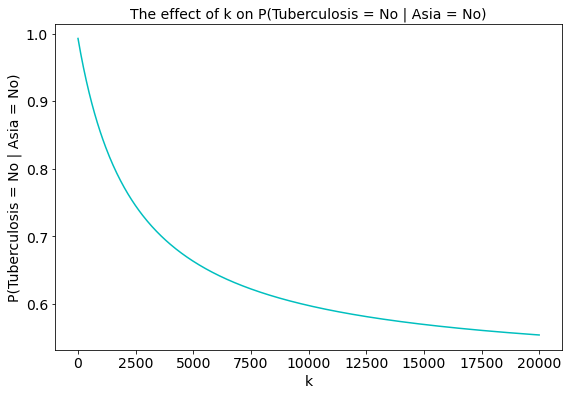

In [53]:
# Just Run this Cell and write what you notice in the cell below.
# This cell may take a while to run
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.title("The effect of k on P(Tuberculosis = No | Asia = No)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("P(Tuberculosis = No | Asia = No)", fontsize=14)
plt.xlabel("k", fontsize=14)

xs = np.linspace(1, 20000, 500)
ys = np.array([parameter_ml_estimate_smoothed(data, query_dictionary, evidence_dictionary, domain_size, my_k) for my_k in xs])
plt.plot(xs, ys, c='c')

<b>Question:</b> What do you observe? Why do you think this is happening? Where will the curve level out?

<b>Answer:</b> With k = 0, the probability is 0.9929335756107409. As k increases, the probability of  P(Tuberculosis = No | Asia = No) decreases as the model becomes more and more general and trusts the observed data (which has a lot of observations of Tuberculosis = No | Asia = No) less. In the most general case, when k tends towards infinity, since the domain size of Tuberculosis is 2, P(Tuberculosis = No | Asia = No) will tend towards 1/Domain Size = 0.5. This makes sense and we can see this slowly happening in our curve. Also note the rate of probability decrease is quick first and then slowly reduces. You should be able to use mathematical reasoning to figure out why this is happening. K is a hyperparameter and it requires tuning - a different topic in this course you will end up learning.

In conclusion, in this section you learnt how to implement Maximum Likelihood based Parameter estimation using data when you may not have the CPT entries from before. You also learnt how to automatically do this in Pomegranate. Lastly, you saw how ML estimates may overfit to data and thus we can use Laplace smoothing to generalise our model. There are various other algorithms for smoothing and parameter estimation such as MAP, the EM algorithm - which you are encouraged to check out but are out of scope for this course.

## 3: Structure Construction and Involved Algorithms

In section 1, we saw how to construct a Bayes Net and run inference using it given the structure and the completed CPT's.

In section 2, we assumed we still had the Bayes Net structure but did not have the CPT entries. Instead we had a bunch of data and we learnt how to use this data to estimate the CPT entires and then run inference as normal.

In this section, we still have our data, but now we will assume we have not been given the Bayes Net structure as well (and lets assume we have no prior/domain knowledge about the structure). Now the goal becomes to try to learn the Bayes Net structure. Once we have done this, we can apply techniques learnt in section 1 and 2 to do anything we normally would with a Bayes Net. Thus, we will formulate the problem in this section as Bayes Net Structure Learning, or BNSL for short.

### 3.1: BNSL Algorithms

There are many algorithms for BSNL and they usually fall under the following fields:

1. Score and Search Based: Keep in mind from our data we will always know the associated states in a Bayes Net. Also, remember that a Bayes Net structure is a DAG. This algorithm searches over the space of all possible (DAGs) and identifies the one that minimizes some objective function. Typical objective functions attempt to balance the log probability of the data given the model (the likelihood). As you may expect, the runtime of this algorithm becomes exponential in the number of variables and thus this algorithm is very unfeasible.

2. Constraint Learning: This typically involves calculating some measure of correlation or co-occurrence to identify an undirected backbone of edges that may exist, and then prune these edges until a DAG is reached. There is no probabilistic interpretation of this type of algrithms so do not spend too much time trying to understand these for now.

3. Approximate Algorithms: The key idea here is that we want to make score and search quick while maintaining its accuracy. Approximate algorithms develop heuristics for score and search to quickly find good structures in a reasonable amount of time. This class of algorithms include the Chow Liu algorithm and the hill climbing algorithm you have seen in lecture.

Pomegranate Currently supports four BNSL algorithms. You do not need to know their details for now as tht is beyond the scope of this course (although we will discuss Chow Liu Trees later), but these are the algorithms:

1. Chow Liu Trees - Add each possible edge in the DAG with an associated weight (representing the "quality" of that edge), and then build a MST using thes weights. Discussed in more detail later on.

2. Greedy - This uses the Score and Search with A* whose heuristics are out of scope.

3. Exact DP - This uses the Score and Search with Dynamic Programing whose details are out of scope.

4. Exact Length Based - Uses the score and search and restricts the number of edges to get a bit of speedup.

### 3.2: Using and Comparing the Algorithms

In Pomegranate, to use any of these algorithms, we use the .from_samples function where we pass in our dataset and the  algorithm name we want to use. As an example, lets try to recreate the structure of the Dyspnea Bayes Net we used before. As a reminder, here is the Bayes Net (assume we don't know this) and the data. Follow the code cells below to see how we can use the data to predict structure.

#### Dyspnoea Bayes Net
<img src="images/2_dyspnoea_net.png" width=500 height=500 />

In [54]:
# The data as a reminder
dyspnea_data.head()

,Asia,Tuberculosis,Smoke,Lung Cancer,Bronchitis,Either,X-ray,Dyspnea
0,Yes,Yes,No,No,No,Yes,No,Yes
1,Yes,No,No,No,No,No,Yes,No
2,No,No,Yes,No,No,No,Yes,No
3,Yes,No,Yes,No,No,No,Yes,No
4,Yes,No,Yes,No,No,No,No,Yes


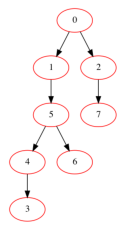

In [55]:
# Using Chow Liu Trees Algorithm to predict Structure
model = BayesianNetwork.from_samples(dyspnea_data, algorithm='chow-liu')
model.plot()
# Note: State 0 corresponds to the 0th column in your data, State 1 to the 1st and so on
# Thus: [0-Asia, 1-Tuberculosis, 2-Smoke, 3-Lung Cancer, 4-Bronchitis, 5-Either, 6-X-Ray, 7-Dyspnea]

As expected, the structure is a Tree. A tree is obviously limited in the structure it can represent, but we can see that the algorithm has done a good job of recognizing certain things such as 0 (Asia) being the root node and node 6 (X-ray) being a leaf node.

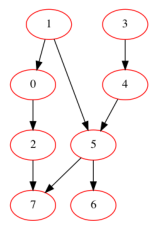

In [56]:
# Using Exact Length Based Algorithm to predict Structure
model = BayesianNetwork.from_samples(dyspnea_data, algorithm='exact')
model.plot()
# Note: State 0 corresponds to the 0th column in your data, State 1 to the 1st and so on
# Thus: [0-Asia, 1-Tuberculosis, 2-Smoke, 3-Lung Cancer, 4-Bronchitis, 5-Either, 6-X-Ray, 7-Dyspnea]

We can see that this structure is actually very similar to the original structure. Althoguh some nodes are switched up  (such as 0 and 1), the overall structure is very similar and when you look at what the states represent this structure makes a lot of sense.

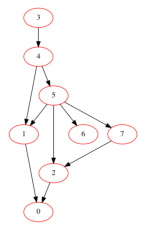

In [57]:
# Using A* Greedy Algorithm to predict Structure
model = BayesianNetwork.from_samples(dyspnea_data, algorithm='greedy')
model.plot()
# Note: State 0 corresponds to the 0th column in your data, State 1 to the 1st and so on
# Thus: [0-Asia, 1-Tuberculosis, 2-Smoke, 3-Lung Cancer, 4-Bronchitis, 5-Either, 6-X-Ray, 7-Dyspnea]

We can see that this structure is a bit far off from the original structure, and this makes sense since we used a greedy approach and trimmed our state space a lot. The structure however does do a good job of modelling some relationships correctly such as those between states 5-6-7.

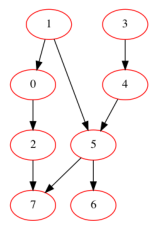

In [58]:
# Using Exact-DP Algorithm to predict Structure
model = BayesianNetwork.from_samples(dyspnea_data, algorithm='exact-dp')
model.plot()
# Note: State 0 corresponds to the 0th column in your data, State 1 to the 1st and so on
# Thus: [0-Asia, 1-Tuberculosis, 2-Smoke, 3-Lung Cancer, 4-Bronchitis, 5-Either, 6-X-Ray, 7-Dyspnea]

This is the exact same graph as the 'exact' algorithm produced. We can see once again that the structure is very similar to the actual structure.

#### Using Large Bayes Nets To Compare Performance of the Algorithms

Consider the following common and much bigger example of a Bayes Net. In this setup we have a picture of a number and the picture is divided into 64 pixels. Each pixel has a brightness value and each pixel depends on the number the picture was representing. Thus, think of this Bayes Net of having 65 states (1 for each pixel and 1 for the number in the picture). 

The structure of the Bayes Net is not important, what is important is that this Bayes Net is much larger than the ones we have dealt with. We want to see how the different algorithms recover the structure of the Bayes Net as we consider more and more states. Run the following cell which generates data, and tries to recover the structure using the different BNSL algorithms while varying the number of states in the Bayes Net.

Note: This cell may take more than 5 minutes to run and you do not need to understand any of the code - just the graphs that are outputted from it. This code is mainly from the Pomegranate Source Repository and is credited to the writer of the repository.

/Users/sarthak/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_class=10, return_X_y=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


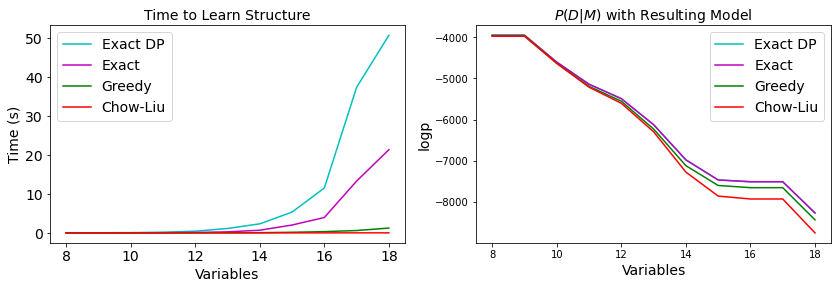

In [59]:
# YOU DO NOT NEED TO UNDERSTAND THIS
X, _ = load_digits(10, True)
X = X > numpy.mean(X)

t1, t2, t3, t4 = [], [], [], []
p1, p2, p3, p4 = [], [], [], []
n_vars = range(8, 19)

for i in n_vars:
    X_ = X[:,:i]

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='exact-dp') # << BNSL done here!
    t1.append(time.time() - tic)
    p1.append(model.log_probability(X_).sum())

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='exact')
    t2.append(time.time() - tic)
    p2.append(model.log_probability(X_).sum())

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='greedy')
    t3.append(time.time() - tic)
    p3.append(model.log_probability(X_).sum())

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='chow-liu')
    t4.append(time.time() - tic)
    p4.append(model.log_probability(X_).sum())
    
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.title("Time to Learn Structure", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.plot(n_vars, t1, c='c', label="Exact DP")
plt.plot(n_vars, t2, c='m', label="Exact")
plt.plot(n_vars, t3, c='g', label="Greedy")
plt.plot(n_vars, t4, c='r', label="Chow-Liu")
plt.legend(fontsize=14, loc=2)

plt.subplot(122)
plt.title("$P(D|M)$ with Resulting Model", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.ylabel("logp", fontsize=14)
plt.plot(n_vars, p1, c='c', label="Exact DP")
plt.plot(n_vars, p2, c='m', label="Exact")
plt.plot(n_vars, p3, c='g', label="Greedy")
plt.plot(n_vars, p4, c='r', label="Chow-Liu")
plt.legend(fontsize=14)

<b>Question</b>: Look at the graphs outputted. The axes on the first graph should make it pretty clear what it is trying to convey. For the second graph, we have the log of P(D|M) on the y-axis. P(D|M) is a measure of how well the built model explains the data and higher values for P(D|M) mean that the model has done a better job of explaining the data. Using these 2 graphs, compare and contrast the 4 algorithms available in Pomegranate. Note: The purple and cyan lines superimpose on the right plot as they produce the same graphs.

<b>Answer</b>: From the graphs we can see that as the number of variables in our Bayes Net increases, the Chow Liu algrithm stays very quick and constantly performs the quickest. This makes sense as it always builds an MST. The greedy A* based algorithm also stays quick but we can see the exact based algorithms blow up in terms of time taken as they consider a pretty large subset of all possible DAG's which increases exponentially with the number of variables.

From the other plot we can make out in terms of performance the quality of the exact based algorithms becomes better and better than the Greedy and Chow Liu algorithms as they consider many more possible DAG's whose effect is more apparent when there are so many DAG's to consider. 

There is a clear time performance tradeoff that we can observe.

### 3.3: Implementing the Chow Liu Tree Algorithm

In the final part of this assignment, you will implement the Chow Liu Tree algorithm you saw in action above and in lecture. We have chosen to implement this algorithm as it is intuitive, relatively simple, and performs quickly and with decent quality for most Bayes Nets. After you implement the alogrithm, you will also get a chance to run it. 

Recall that the algorithm always returns a tree and this is how it functions:

#### Chow Liu Algorithm
<img src="images/3_chow_liu_1.png" width=500 height=500 />
<img src="images/3_chow_liu_2.png" width=500 height=500 />

<b> Note: </b> For this class you do not need to know how to find the Maximum Weight Spanning Tree. This will be done for you when you implement the algorithm. You just need to understand that it is the tree such that the sum of the weights of the edges in the tree is maximized.

Convince yourself that this is the same as giving each weight -I and then finding a Minimum Weight Spanning Tree (MWST). You should use this strategy as we will let you call a function that directly builds a mimimum spanning tree for you. Also remind yourself from lecture how a higher value for I corresponds to a greater need for an edge between the two nodes in question.

Using all the information you have till nwow, implement the chow_liu_tree function - which takes in an argument called data - which is your dataframe. You will have to also fill in the helper functions and these will start to make more and more sense to you as you dive into the code. Lastly, for this problem we will be using the Networkx library for ease of implementation. In fact, the Pomegranate library uses NetworkX as well. All NetworkX syntax has been provided where needed and you are encouraged to search up relevant documentation if you feel the need.

In [60]:
def get_joint_marginal(data, u, v):
    """
    Return the marginal distribution for the u'th and v'th indexed features of data
    Return a dictionary of form {(u_value1, v_value1): probability, (u_value2, v_value2: probability}
    """
    total_rows = len(data)
    marginal = {}
    for i in range(len(data)): # Go through all rows
        value_of_u_in_row_i = data.iloc[i, u] # Find value of u'th feature in i'th row
        value_of_v_in_row_i = data.iloc[i, v] # Find value of v'th feature in i'th row
        marginal[(value_of_u_in_row_i, value_of_v_in_row_i)] = \
        marginal.get((value_of_u_in_row_i, value_of_v_in_row_i), 0) + (1 / total_rows) # Increment associated probability
    return marginal

def get_marginal(data, u):
    """
    Return the marginal distribution for the u'th indexed feature of data
    Return a dictionary of form {value1: probability, value2: probability}
    """
    total_rows = len(data)
    marginal = {}
    for i in range(len(data)): # Go through all rows
        value_of_u_in_row_i = data.iloc[i, u] # Find value of u'th feature in i'th row
        marginal[value_of_u_in_row_i] = marginal.get(value_of_u_in_row_i, 0) + (1 / total_rows) # Increment associated probability
    return marginal

def calculate_edge_weight(data, u, v):
    """
    Data is your data
    u and v are the indices of the features for which we are calculating "weight"
    """   
    I = 0
    
    u_marginal = get_marginal(data, u) # Get marginal distributions required by the algorithm
    v_marginal = get_marginal(data, v)
    joint_marginal = get_joint_marginal(data, u, v)

    for u_value, u_value_probability in u_marginal.items():
        for v_value, v_value_probability in v_marginal.items():
            if (u_value, v_value) in joint_marginal.keys(): # Go through the marginals and the joint as in algorithm
                # Do the Calculation Involved in finding weights
                I += joint_marginal[(u_value, v_value)] * (np.log(joint_marginal[(u_value, v_value)])\
                                                           - np.log(u_value_probability) - np.log(v_value_probability))
    return I

def chow_liu_tree(data):
    """
    Approximate a BN structure using the Chow Liu Algorithm and observation data.
    data argument is of type pd.DataFrame
    Uses networkx library and returned stucture is in the form of a networkx graph.
    """
    G = nx.Graph() # Initialises a networkx graph called G
    number_of_states = len(data.columns)
    
    for i in range(number_of_states):
        G.add_node(i) # Add a node for each state. State i corresponds to the ith column in data
        
    for v in range(number_of_states):
        for u in range(number_of_states): # For each possible edge
            I = calculate_edge_weight(data, u, v) # Calculate weight of edge
            G.add_edge(u, v, weight= -I) # Add edge to G with negative weight
            

    return nx.minimum_spanning_tree(G) # Return MWST

If you have a correct implementation, running the next cell will approximate the structure of the Dyspnea BN we saw before using the Chow Liu Algorithm. Running the next cell will output the edges in the structure your algorithm returned. Compare this with the Pomegranate implemetation. Do you get the same thing? If so, well done - you implemented the algorithm correctly!

Note: Although your implementation of the algorithm may have all the same edges as the Pomegranate implementation, the direction of a couple of the edges may be different when the two versions are compared. This is okay, as each node only has one parent and regardless of the edge direction, you can end up encoding the same likelihood as mutual information is symmetric.

In [61]:
# Using Our Implementation
built_structure = chow_liu_tree(dyspnea_data)
built_structure.edges

EdgeView([(0, 2), (0, 1), (1, 5), (2, 7), (3, 4), (4, 5), (5, 6)])

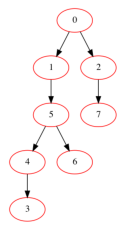

In [62]:
# Using Pomegranate Implementation 
model = BayesianNetwork.from_samples(dyspnea_data, algorithm='chow-liu')
model.plot()

You may have noticed your version ran a lot slower - do not worry about that.

The important thing is you now know how to construct a BN structure using Pomegranate and different algoithms and you have managed to implement one of those algorithms yourself!

This marks the end of section 3 and the end of the assignment. Section 4 goes over learning objectives this assignment  was designed to fulfill and section 5 is references used for the making of this assignment.

## 4: Takeaways and Learning Objectives Satisfied

In this assignment you learnt a lot about constructing Bayes Net in Python using Pomegranate, using these Bayes Nets for inference, parameter estimation and structure estimation. Along the way, you got experience with how to do these different tasks and you also implemented a few of them yourself from scratch. You should realise by now that libraries such as Pomegranate are pretty useful when it comes to Bayes Nets - this is because Bayes Nets can pretty quickly get large and running inference, likelihood calculations can get arduous very easily. Moreover, just given some data, you are now equipped to first find a structure, then do parameter estimation, and any inference you may need to do. You also worked with real life datasets and Bayes Nets. Here is a more detailed explanation of the learning objectives achieved in each section:

<b>Section 1</b>: This section taught you how Pomegranate can be used to build a Bayes Net whose structure and CPT's you know. You saw how once you have 'baked' your model, you can answer any query you may have by running inference using Pomegranate's well defined and easy to use interface. Furthermore, in this section you got practice in converting a problem description to a Bayes Net with associated CPT's. You then ran inference to understand the dynamics of the Monty Hall problem. At the end of the section, you should have got enough practice on constructing a Bayes Net and knowing how to answer any queries using it. You answered conitional probability, marginal, and joint queries easily using Pomegranate.



<b>Section 2</b>: This section taught you how Pomegranate can be used to estimate the entries of a CPT in a Bayes Net whose structure you know and for which you have been given observed data for each variable in the net. You saw how once you have 'baked' your model with each CPT entry as 0, you can 'fit' to the data you have observed and this will automatically populate the CPT's for you using the ML Parameter estimation procedure. Furthermore, you saw that once this is done you can run inference as normal. In fact, you understood the ML Estimation algorithm and implemented it on your own and saw it performed exactly like the Pomegranate version. Lastly, you learnt about overfitting to observed data and the problem of zero- and to solve this you understood Laplace smoothing and added this functionality to your custom built ML Parameter Estimation algorithm. Overall, you got a good grasp of implementing and understanding parameter observation having observed some data.



<b>Section 3</b>: This section taught you how Pomegranate can be used to estimate the structure itself of  Bayes Net for which you have been given observed data for each variable in the net. You saw how there are various algorithms that can help us out with this process and you compared and contrasted the four algorithms that Pomegranate implements for this purpose - understanding the tradeoff between speed and 'goodness'. We looked at the Chow Liu Tree algorithm in detail and you succcessfully implemented this from scratch and saw it gave you results similar to the Pomegranate version. All in all, at the end of this section you were well aware of how to go from just observed data to finding a structure (assuming no prior domain knowledge), to finding parameters, to running vanilla inference.

## 4: References

[https://pomegranate.readthedocs.io/en/latest/BayesianNetwork.html#prediction]

[https://www.bnlearn.com/about/slides/slides-ibm16.pdf]

[https://arxiv.org/ftp/arxiv/papers/1304/1304.2736.pdf]

[http://www.cs.cmu.edu/~guestrin/Class/10701/recitations/r10/11152007chowliu.pdf]

[https://www.bnlearn.com/bnrepository/]